In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import os
os.chdir('/content/drive/Shareddrives/CS229Buddies/project')

In [93]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import collections
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, plot_precision_recall_curve
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import operator
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy import stats

In [94]:
df = pd.read_csv('data/GSE113957_fpkm.txt', sep = '\t')
df = df.T
transcript_ids = list(df.loc['Transcript ID'])

df = df.drop(['Transcript ID', 'chr', 'start', 'end', 'strand', 'Length', 'Copies', 'Annotation/Divergence'], axis=0)
df['pids'] = [column.lower().split('_')[0] for column in df.index]
hgps = set(['139', '141', '197', '198', '199', '200', '201', '202', '203', '204'])
control_df = df[~df.pids.isin(hgps)]
hgps_df = df[df.pids.isin(hgps)]
control_df = control_df.drop(['pids'], axis = 1)
hgps_df = hgps_df.drop(['pids'], axis = 1)

control_df.columns = transcript_ids
hgps_df.columns = transcript_ids

total_df = control_df.append(hgps_df)
annot=pd.read_csv("data/uniprot.tab", sep='\t')
annot=pd.read_csv("data/uniprot.tab", sep='\t')
name_d=pd.Series(annot["Gene names"].values,index=annot["yourlist:M202105245C475328CEF75220C360D524E9D456CE20BD46G"]).to_dict()
n=dict()
for k,v in name_d.items():
  if str(v)!="nan" and str(k)!="nan":
    n[k]=v.split(" ")[0]
control_df=control_df[[x for x in control_df.columns if x  in n.keys()]]
control_df.columns=[n[x] for x in control_df.columns if x  in n.keys()]

In [95]:
control_df = control_df.sum(axis=1, level=0)

In [96]:
control_df

,MPV17L,AFF4,ZGLP1,CHDH,C12orf74,ZFP90,KDM6B,DCLRE1A,LRRC3C,P2RY14,SC5DL,DSN1,KCP,SKP1,ADAMTS9,PRPF3,PARP14,HOXB1,CDV3,NELFA,P2RX3,UBR5,COASY,AP1S3,AP2M1,SPDYE3,FAM160B1,TMEM88B,RAP2B,GSDMC,FAIM,ABCC6,PCOTH,CRABP2,CARD16,SULT1C3,LTV1,AID,SGIP1,ABCC3,...,DCPS,TCTN2,DCD,SPDYE2B,SLC35G6,NPFF,HEY2,JPT1,CHID1,FLJ13052,UMODL1,RABEPK,DNAJB2,STAMBPL1,DPY19L1,EIF3M,COX6B2,FOXF2,ZNF320,EIF5A,GCGR,ACTRT3,PCSK6,PDZD7,HEL-S-41,CYBC1,MYO10,ADGRA3,SLA,MED20,GAS2L2,BPHL,PCNX4,TCEAL2,PNPLA5,RUFY3,FGFRL1,GALNT8,CCNG2,SLC25A48
101_19yr_Female_Caucasian,0.133,16.980,0.387,0.115,0.0,5.500,1.308,2.143,0.000,0.000,5.127,14.031,0.018,68.975,0.620,19.216,2.564,0.0,52.032,4.525,0.000,12.938,14.259,0.541,277.734,0.000,5.743,0.0,3.595,0.000,9.665,0.000,0.797,148.414,0.733,0.0,14.825,0.000,1.138,5.757,...,9.085,5.460,0.0,0.0,0.000,0.517,0.016,63.004,16.377,11.960,0.017,14.666,16.771,4.727,10.064,44.714,0.077,3.535,2.652,225.407,0.0,1.994,0.030,0.290,1.875,11.888,17.190,2.770,0.0,9.433,0.014,3.978,17.081,0.000,0.000,4.349,29.242,0.040,6.139,0.0
102_19yr_Male_Caucasian,0.213,16.772,0.168,0.077,0.0,6.473,1.357,1.952,0.000,0.000,3.701,13.255,0.000,61.827,0.211,11.628,1.296,0.0,36.853,3.693,0.000,11.535,11.706,0.202,284.640,0.000,5.608,0.0,2.291,0.070,6.522,0.000,0.773,315.897,0.189,0.0,9.692,0.000,0.768,7.458,...,4.988,5.093,0.0,0.0,0.000,0.289,0.000,51.358,23.395,15.450,0.000,10.447,13.185,5.360,9.991,29.864,0.029,2.435,2.613,205.338,0.0,2.873,0.022,0.441,2.624,12.583,18.545,4.020,0.0,6.454,0.000,3.378,14.215,0.000,0.000,5.642,31.561,0.000,5.603,0.0
103_19yr_Male_Caucasian,0.054,16.206,0.410,0.284,0.0,6.770,1.495,1.881,0.046,0.000,3.356,9.516,0.009,67.533,0.326,12.417,1.840,0.0,42.325,4.726,0.000,10.953,14.440,0.182,301.299,0.000,6.187,0.0,2.293,0.000,8.685,0.000,1.418,266.717,1.021,0.0,11.141,0.000,0.906,7.217,...,6.331,5.080,0.0,0.0,0.000,1.134,0.000,56.853,21.832,16.853,0.000,13.672,15.413,4.526,10.105,34.743,0.195,3.389,2.404,219.336,0.0,2.488,0.038,0.712,2.508,14.085,15.557,3.193,0.0,8.573,0.000,5.841,15.057,0.037,0.000,6.132,43.446,0.000,6.030,0.0
104_19yr_Male_Caucasian,0.066,15.345,0.148,0.304,0.0,5.773,1.688,1.927,0.056,0.039,2.455,9.884,0.000,62.057,0.503,12.878,1.867,0.0,31.844,5.389,0.000,11.372,13.423,0.183,315.602,0.000,5.836,0.0,2.931,0.018,8.092,0.000,0.612,125.909,0.974,0.0,9.815,0.000,0.800,4.697,...,6.785,2.450,0.0,0.0,0.000,1.488,0.000,50.358,22.499,13.521,0.010,13.590,16.273,5.067,8.320,31.115,0.059,3.466,1.996,183.929,0.0,3.150,0.034,0.573,2.339,14.824,15.571,3.297,0.0,8.485,0.000,2.237,14.247,0.000,0.022,3.752,39.371,0.000,5.048,0.0
105_20yr_Male_Caucasian,0.156,16.873,0.252,0.094,0.0,5.052,1.384,2.815,0.000,0.000,5.745,13.131,0.011,63.981,0.242,14.719,1.448,0.0,43.607,4.981,0.000,11.345,14.707,0.398,283.420,0.016,6.723,0.0,1.785,0.018,6.667,0.000,0.934,66.549,0.264,0.0,13.647,0.018,0.682,5.021,...,7.448,4.852,0.0,0.0,0.000,1.152,0.000,70.406,17.125,12.348,0.000,11.550,12.744,4.777,9.909,39.632,0.000,1.822,2.437,239.498,0.0,1.517,0.081,0.097,0.794,11.617,15.222,4.057,0.0,8.247,0.000,3.537,14.088,0.091,0.000,4.833,18.592,0.000,3.794,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94_12_male_Caucasian,0.214,16.103,0.323,0.086,0.0,4.877,1.369,2.212,0.000,0.000,2.828,15.166,0.011,68.210,0.340,12.354,1.515,0.0,38.405,4.744,0.000,11.523,10.250,0.213,296.900,0.000,6.835,0.0,2.289,0.020,9.337,0.000,0.866,91.985,0.354,0.0,13.846,0.000,0.525,4.576,...,4.795,4.050,0.0,0.0,0.000,1.167,0.000,58.212,24.508,12.198,0.011,11.990,14.284,5.188,6.789,37.820,0.032,2.996,1.594,220.301,0.0,2.155,0.012,0.208,2.613,14.377,10.419,2.737,0.0,7.695,0.000,2.666,14.963,0.049,0.000,4.494,28.903,0.000,6.531,0.0
95_13yr_Male_WhiTEEASTINDIAN,0.041,15.899,0.486,0.087,0.0,5.026,1.080,2.565,0.0

In [97]:
def filter_genes(X):
  genes=[]
  for col in X.columns:
    vec=np.array(X[col])
    if vec.max()> 5 and vec.max()-vec.min()>5*vec.min():
      genes.append(col)
  return X[genes]

In [98]:
control_df=filter_genes(control_df)
labels = control_df.index
ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
sex = [int(label.lower().split('_')[2] == 'male') for label in labels]
race = [label.lower().split('_')[3] for label in labels]

In [99]:
GO=pd.read_csv("gseapy_results/GO_Biological_Process_2018.human.enrichr.reports.txt", sep="\t")
GO_map=pd.Series(GO["Genes"].values,index=GO["Term"]).to_dict()
l=list(GO_map.keys())
for k in l:
  genes=set(GO_map[k].split(";"))
  if len(genes)>10 & len(genes)<500:
    GO_map[k]=genes&set(control_df.columns)
  else:
    GO_map.pop(k)
len(GO_map)

4555

In [100]:
len(GO)

5103

In [101]:
for col in control_df.columns:
  control_df[col]=(control_df[col]-np.array(control_df[col]).mean())/np.array(control_df[col]).std()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
gene_corr=dict()
for gene in control_df.columns:
  gene_corr[gene]=stats.pearsonr(control_df[gene],np.array(ages))[0]

In [103]:
gene_corr

{'DSN1': -0.3208489828150488,
 'PARP14': 0.39077292412526843,
 'NELFA': -0.4396378105922057,
 'RAP2B': 0.27757059844436643,
 'CRABP2': -0.11266504698705268,
 'CARD16': 0.28909403977076564,
 'SGIP1': 0.3503720170070752,
 'ABCC3': 0.3722618130264223,
 'ZBTB18': -0.38190429923753183,
 'RCAN2': 0.4504692536115278,
 'LAGE3': -0.3480940887198668,
 'JDP2': 0.07153461651026122,
 'RARRES2': 0.1860827508393911,
 'ZNF185': 0.05000259702204211,
 'MTRNR2L8': -0.12089500973456213,
 'TRIM11': -0.3814427166037457,
 'RHOBTB3': 0.13017856615221485,
 'MGST2': 0.19076936498921565,
 'SLC25A29': -0.32422155931027663,
 'ADAMTS4': -0.5038767945318303,
 'MRPL28': -0.5776808353907765,
 'SYNPO2': 0.15383474226997174,
 'FRMD4A': -0.07974124764416586,
 'CALHM5': 0.20468840897287857,
 'NSUN5': -0.48056766655198385,
 'CAV2': 0.4668228881810045,
 'ApoL6': 0.4025249533503589,
 'CD248': -0.17655417542572124,
 'SMPDL3A': 0.35646975080528315,
 'B4GALNT1': -0.38484822454922524,
 'DKFZp686H0286': 0.33145046964569935,
 'hCG

In [104]:
control_df["PARP14"].std()

1.0037807318213263

In [105]:
activity_map=dict()
gene_map=dict()
j=0
for k, v in GO_map.items():
  j+=1
  print(j)
  if len(v)>0:
    corrs=[]
    # print(k)
    for gene in v:
      corrs.append(gene_corr[gene])
    df=pd.DataFrame(data=[v,corrs]).T
    df[1]=df[1].astype("float")
    mean=np.array(corrs).mean()
    df=df.sort_values(by=1, ascending=(np.array(corrs).mean()<0))
    a=control_df.loc[:,df.iloc[0,0]].copy()
    a_sum=control_df.loc[:,df.iloc[0,0]].copy()
    prop_a=control_df.loc[:,df.iloc[0,0]].copy()
    n=1
    best_r=0
    for i in range(1,len(list(df.index))):
      n+=1
      a_sum+=control_df.loc[:,df.iloc[i,0]]
      prop_a=a_sum/n
      prop_r=stats.pearsonr(prop_a,np.array(ages))[0]**2
      # print(prop_r)
      if prop_r<best_r:
        break 
      best_r=prop_r
      a=prop_a
    activity_map[k]=a
    gene_map[k]=list(df.iloc[:n-1,0])
    # print(gene_map[k])
  
  
 



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [106]:
GO_map["thyroid gland development (GO:0030878)"]

KeyError: ignored

In [107]:
activity_output=pd.DataFrame.from_dict(activity_map)
activity_output.to_csv("results/lee_scores.csv")

In [108]:
pd.DataFrame.from_dict(gene_map, orient='index').to_csv("results/lee_genes.csv")

In [109]:
activity_output

,B cell differentiation (GO:0030183),regulation of cellular metabolic process (GO:0031323),negative regulation of phosphatase activity (GO:0010923),cartilage development (GO:0051216),regulation of potassium ion transport (GO:0043266),response to dsRNA (GO:0043331),carbohydrate homeostasis (GO:0033500),positive regulation of osteoblast differentiation (GO:0045669),positive regulation of macroautophagy (GO:0016239),anterograde trans-synaptic signaling (GO:0098916),skin development (GO:0043588),potassium ion transport (GO:0006813),regulation of interferon-gamma production (GO:0032649),regulation of osteoblast differentiation (GO:0045667),positive regulation of cell differentiation (GO:0045597),keratinocyte differentiation (GO:0030216),zinc II ion transport (GO:0006829),positive regulation of autophagy (GO:0010508),epidermal cell differentiation (GO:0009913),chemical synaptic transmission (GO:0007268),mesenchymal cell differentiation (GO:0048762),protein targeting to ER (GO:0045047),inositol phosphate-mediated signaling (GO:0048016),proteoglycan metabolic process (GO:0006029),regulation of lipoprotein lipase activity (GO:0051004),SRP-dependent cotranslational protein targeting to membrane (GO:0006614),monovalent inorganic cation transport (GO:0015672),lymphocyte differentiation (GO:0030098),regulation of cation transmembrane transport (GO:1904062),regulation of platelet activation (GO:0010543),positive regulation of epithelial cell differentiation (GO:0030858),nervous system development (GO:0007399),synaptic vesicle recycling (GO:0036465),negative regulation of dephosphorylation (GO:0035305),positive regulation of cell projection organization (GO:0031346),metal ion transport (GO:0030001),ncRNA processing (GO:0034470),cotranslational protein targeting to membrane (GO:0006613),regulation of peptidyl-serine phosphorylation of STAT protein (GO:0033139),regulation of dephosphorylation (GO:0035303),...,tRNA aminoacylation (GO:0043039),sulfur compound biosynthetic process (GO:0044272),endocytosis (GO:0006897),antigen receptor-mediated signaling pathway (GO:0050851),regulation of immune response (GO:0050776),defense response to bacterium (GO:0042742),receptor-mediated endocytosis (GO:0006898),Fc receptor signaling pathway (GO:0038093),Fc-epsilon receptor signaling pathway (GO:0038095),Fc receptor mediated stimulatory signaling pathway (GO:0002431),phagocytosis (GO:0006909),Fc-gamma receptor signaling pathway (GO:0038094),Fc-gamma receptor signaling pathway involved in phagocytosis (GO:0038096),regulation of protein processing (GO:0070613),nucleosome organization (GO:0034728),humoral immune response mediated by circulating immunoglobulin (GO:0002455),tRNA aminoacylation for protein translation (GO:0006418),"complement activation, classical pathway (GO:0006958)",regulation of acute inflammatory response (GO:0002673),positive regulation of B cell activation (GO:0050871),regulation of immune effector process (GO:0002697),regulation of humoral immune response (GO:0002920),protein-DNA complex assembly (GO:0065004),regulation of complement activation (GO:0030449),regulation of protein activation cascade (GO:2000257),positive regulation of lymphocyte activation (GO:0051251),"phagocytosis, engulfment (GO:0006911)",B cell receptor signaling pathway (GO:0050853),plasma membrane invagination (GO:0099024),regulation of B cell activation (GO:0050864),purine ribonucleotide biosynthetic process (GO:0009152),chromatin assembly (GO:0031497),nucleosome assembly (GO:0006334),ATP metabolic process (GO:0046034),inner mitochondrial membrane organization (GO:0007007),purine ribonucleoside monophosphate biosynthetic process (GO:0009168),ATP biosynthetic process (GO:0006754),ATP synthesis coupled proton transport (GO:0015986),septin ring organization (GO:0031106),septin ring assembly (GO:0000921)
101_19yr_Female_Caucasian,0.055195,0.275242,0.093209,-0.201016,-0.131159,0.205954,-0.262510,-0.189572,-0.414467,-0.425132,0.276805,-0.548274,-0.274734,-0.291018,-0.189627

In [110]:
total_numpy = activity_output.to_numpy()
pca = PCA(n_components=2)
scaler = StandardScaler()
x = scaler.fit_transform(total_numpy)
principlecomponents = pca.fit_transform(x)
principledf = pd.DataFrame(principlecomponents)
principledf.columns = ['PC1', 'PC2']
principledf['age'] = ages
principledf['sex'] = sex

In [111]:
principledf_withouthgps = principledf.iloc[:-10]
principledf_onlyhgps = principledf.iloc[-10:]

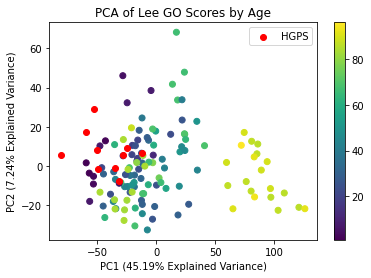

In [112]:
plt.scatter(principledf_withouthgps['PC1'], principledf_withouthgps['PC2'], c=principledf_withouthgps['age'], cmap='viridis')
plt.colorbar()
plt.scatter(principledf_onlyhgps['PC1'], principledf_onlyhgps['PC2'], c='red', label = 'HGPS')
plt.title("PCA of Lee GO Scores by Age")
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100, 2)) + '% Explained Variance)')
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100, 2)) + '% Explained Variance)')
plt.legend()
plt.savefig('results/Lee_GO_pca_by_age.png')

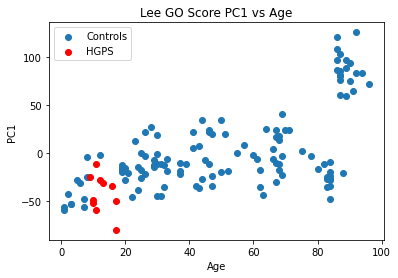

In [113]:
plt.scatter(principledf_withouthgps['age'], principledf_withouthgps['PC1'], label = "Controls")
plt.scatter(principledf_onlyhgps['age'], principledf_onlyhgps['PC1'], c = 'red', label = "HGPS")
plt.xlabel('Age')
plt.ylabel('PC1')
plt.title("Lee GO Score PC1 vs Age")
plt.legend()
plt.savefig('results/Lee_GO_age_by_pc1.png')

In [114]:
stats.pearsonr(principledf_withouthgps['age'], principledf_withouthgps['PC1'])

(0.6052584136078193, 1.2139441249649844e-13)

In [115]:
X

,B cell differentiation (GO:0030183),regulation of cellular metabolic process (GO:0031323),negative regulation of phosphatase activity (GO:0010923),cartilage development (GO:0051216),regulation of potassium ion transport (GO:0043266),response to dsRNA (GO:0043331),carbohydrate homeostasis (GO:0033500),positive regulation of osteoblast differentiation (GO:0045669),positive regulation of macroautophagy (GO:0016239),anterograde trans-synaptic signaling (GO:0098916),skin development (GO:0043588),potassium ion transport (GO:0006813),regulation of interferon-gamma production (GO:0032649),regulation of osteoblast differentiation (GO:0045667),positive regulation of cell differentiation (GO:0045597),keratinocyte differentiation (GO:0030216),zinc II ion transport (GO:0006829),positive regulation of autophagy (GO:0010508),epidermal cell differentiation (GO:0009913),chemical synaptic transmission (GO:0007268),mesenchymal cell differentiation (GO:0048762),protein targeting to ER (GO:0045047),inositol phosphate-mediated signaling (GO:0048016),proteoglycan metabolic process (GO:0006029),regulation of lipoprotein lipase activity (GO:0051004),SRP-dependent cotranslational protein targeting to membrane (GO:0006614),monovalent inorganic cation transport (GO:0015672),lymphocyte differentiation (GO:0030098),regulation of cation transmembrane transport (GO:1904062),regulation of platelet activation (GO:0010543),positive regulation of epithelial cell differentiation (GO:0030858),nervous system development (GO:0007399),synaptic vesicle recycling (GO:0036465),negative regulation of dephosphorylation (GO:0035305),positive regulation of cell projection organization (GO:0031346),metal ion transport (GO:0030001),ncRNA processing (GO:0034470),cotranslational protein targeting to membrane (GO:0006613),regulation of peptidyl-serine phosphorylation of STAT protein (GO:0033139),regulation of dephosphorylation (GO:0035303),...,tRNA aminoacylation (GO:0043039),sulfur compound biosynthetic process (GO:0044272),endocytosis (GO:0006897),antigen receptor-mediated signaling pathway (GO:0050851),regulation of immune response (GO:0050776),defense response to bacterium (GO:0042742),receptor-mediated endocytosis (GO:0006898),Fc receptor signaling pathway (GO:0038093),Fc-epsilon receptor signaling pathway (GO:0038095),Fc receptor mediated stimulatory signaling pathway (GO:0002431),phagocytosis (GO:0006909),Fc-gamma receptor signaling pathway (GO:0038094),Fc-gamma receptor signaling pathway involved in phagocytosis (GO:0038096),regulation of protein processing (GO:0070613),nucleosome organization (GO:0034728),humoral immune response mediated by circulating immunoglobulin (GO:0002455),tRNA aminoacylation for protein translation (GO:0006418),"complement activation, classical pathway (GO:0006958)",regulation of acute inflammatory response (GO:0002673),positive regulation of B cell activation (GO:0050871),regulation of immune effector process (GO:0002697),regulation of humoral immune response (GO:0002920),protein-DNA complex assembly (GO:0065004),regulation of complement activation (GO:0030449),regulation of protein activation cascade (GO:2000257),positive regulation of lymphocyte activation (GO:0051251),"phagocytosis, engulfment (GO:0006911)",B cell receptor signaling pathway (GO:0050853),plasma membrane invagination (GO:0099024),regulation of B cell activation (GO:0050864),purine ribonucleotide biosynthetic process (GO:0009152),chromatin assembly (GO:0031497),nucleosome assembly (GO:0006334),ATP metabolic process (GO:0046034),inner mitochondrial membrane organization (GO:0007007),purine ribonucleoside monophosphate biosynthetic process (GO:0009168),ATP biosynthetic process (GO:0006754),ATP synthesis coupled proton transport (GO:0015986),septin ring organization (GO:0031106),septin ring assembly (GO:0000921)
101_19yr_Female_Caucasian,0.055195,0.275242,0.093209,-0.201016,-0.131159,0.205954,-0.262510,-0.189572,-0.414467,-0.425132,0.276805,-0.548274,-0.274734,-0.291018,-0.189627

In [116]:
X_new

array([[ 0.05519533,  0.27524169,  0.09320855, ..., -0.64977505,
         0.02541398,  0.02541398],
       [-0.38134897, -0.13022664, -0.43153107, ...,  0.09386777,
         0.22517394,  0.22517394],
       [-0.05718306,  0.16554259, -0.2178559 , ...,  1.0723922 ,
         0.43576944,  0.43576944],
       ...,
       [ 0.90598188,  0.24307609,  0.07684557, ..., -0.26604768,
         0.30496594,  0.30496594],
       [ 0.66448581,  0.85367807,  1.94131758, ...,  2.20899289,
         0.29887129,  0.29887129],
       [ 0.87962302,  0.61532687,  1.85970168, ...,  0.411155  ,
         0.02156446,  0.02156446]])

In [117]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression

In [131]:
r=[]
loo=LeaveOneOut()
X=activity_output
# X=X.reset_index()
# X=X.drop(["index"], axis=1)
labels = list(activity_output.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)


for j in np.linspace(500,600,20):
  feature_selection=SelectKBest(mutual_info_regression,k=int(j))
  X_new=feature_selection.fit_transform(X.copy(), y)
  y_pred=[]
  y_act=[]
  print(j)
  for train_index, test_index in loo.split(X_new):
    X_train, X_test = X_new[train_index], X_new[test_index]
    n_genes.append(X_train.shape[1])
    y_train, y_test = y[train_index], y[test_index]
    reg=LinearRegression().fit(X_train,y_train)
    y_pred.append(reg.predict(X_test))
    y_act.append(y_test)
  y_pred = np.array([y[0] for y in y_pred])
  y_act = np.array([y[0] for y in y_act])
  r2, p = pearsonr((y_act),(y_pred))
  r.append(r2)

500.0
505.2631578947368
510.5263157894737
515.7894736842105
521.0526315789474
526.3157894736842
531.578947368421
536.8421052631579
542.1052631578948
547.3684210526316
552.6315789473684
557.8947368421053
563.1578947368421
568.421052631579
573.6842105263158
578.9473684210526
584.2105263157895
589.4736842105264
594.7368421052631
600.0


In [214]:
feature_selection=SelectKBest(mutual_info_regression,k=500)
X_new=feature_selection.fit_transform(X.copy(), y)

In [215]:
reg=LinearRegression().fit(X_new,y)

In [148]:
reg.coef_

array([-1.86849012, -0.1680452 , -2.21728968, -0.5457276 , -0.45436218,
       -1.85453633, -2.23601955,  2.93834875,  0.69758716, -2.62630042,
        2.78751264,  1.25137577,  0.32824473,  1.28325751,  3.0482349 ,
       -0.90830793,  0.83282629, -2.68872667, -2.37619222, -0.16784571,
        0.83398803, -3.92806971,  0.22684717, -0.10424081,  2.81912141,
       -1.85587178, -0.95807165,  0.96601818, -3.44408487, -1.27472155,
       -0.164415  ,  2.1301002 ,  2.98008449, -1.10607129,  1.60825835,
       -0.43610842,  0.89671132, -2.32465964,  2.45431491, -2.44419915,
        2.98543318, -2.31209505, -2.02375827, -0.43582474,  1.76067987,
       -2.62501717, -4.65417749,  2.58735674,  1.77624063, -1.44761977,
       -3.20801577,  0.43654414,  2.75550567, -2.55880834,  0.95321655,
       -3.00626725, -2.45252395,  1.75212974, -1.03325327, -3.74041194,
       -0.89898629,  0.17069801, -2.26576977, -3.18265694, -1.03281217,
       -3.09143035,  2.28535035,  3.20497194,  4.72417753,  0.17

In [216]:
t=feature_selection.get_support()

In [217]:
a=[x[0] for x in zip(list(activity_output.columns),list(t)) if x[1]]

In [218]:
features=pd.DataFrame([a,reg.coef_]).T.sort_values(by=1, ascending=False)
features=features.set_index(0)
features

,1
0,
heart morphogenesis (GO:0003007),7.8568
clathrin-dependent endocytosis (GO:0072583),7.28953
negative regulation of tumor necrosis factor superfamily cytokine production (GO:1903556),6.82012
cellular response to light stimulus (GO:0071482),6.38504
cell-cell junction maintenance (GO:0045217),6.06939
...,...
extracellular matrix organization (GO:0030198),-5.40824
AMP metabolic process (GO:0046033),-5.52925
"retrograde transport, endosome to plasma membrane (GO:1990126)",-5.71331


In [164]:
features.to_csv("GO_lee_features.csv")

In [219]:
GSEA=pd.read_csv("GO_GSEA_features.csv")

In [220]:
GSEA

,0,1
0,negative regulation of cytokine secretion (GO:...,263.858888
1,regulation of epidermal cell differentiation (...,260.696690
2,negative regulation of transcription regulator...,225.683664
3,regulation of ubiquitin protein ligase activit...,206.307591
4,regulation of developmental growth (GO:0048638),205.515456
...,...,...
495,regulation of plasma membrane bounded cell pro...,-185.426648
496,negative regulation of Notch signaling pathway...,-202.973167
497,regulation of synaptic vesicle exocytosis (GO:...,-207.797500
498,regulation of vascular endothelial growth fact...,-266.000636


In [221]:
len(set(GSEA.iloc[:,0]) & set(features.index))/len(set(GSEA.iloc[:,0]) | set(features.index))

0.14285714285714285

In [188]:
features_common=features.loc[set(GSEA.iloc[:,0]) & set(features.index),:]
features_common['rank']=features_common[1].rank()
features_common

,1,rank
0,,
neuropeptide signaling pathway (GO:0007218),-0.00227498,1155.0
unsaturated fatty acid biosynthetic process (GO:0006636),-0.191827,116.0
negative regulation of binding (GO:0051100),0.0314059,1489.0
"DNA catabolic process, endonucleolytic (GO:0000737)",-0.164837,176.0
neutrophil degranulation (GO:0043312),0.133801,2021.0
...,...,...
negative regulation of smooth muscle cell proliferation (GO:0048662),-0.038528,835.0
transcription initiation from RNA polymerase I promoter (GO:0006361),-0.0741917,551.5
defense response to Gram-negative bacterium (GO:0050829),0.0438024,1573.5


In [207]:
GSEA=GSEA.set_index("0")
GSEA=GSEA.loc[set(GSEA.index) & set(features.index),:]

In [208]:

GSEA['rank']=GSEA["1"].rank()
GSEA

,1,rank
0,,
neuropeptide signaling pathway (GO:0007218),-3.353182,771.0
unsaturated fatty acid biosynthetic process (GO:0006636),6.815905,1735.0
negative regulation of binding (GO:0051100),-7.640983,446.0
"DNA catabolic process, endonucleolytic (GO:0000737)",-1.364113,986.0
neutrophil degranulation (GO:0043312),0.740395,1182.0
...,...,...
negative regulation of smooth muscle cell proliferation (GO:0048662),2.251128,1329.0
transcription initiation from RNA polymerase I promoter (GO:0006361),-0.997917,1011.0
defense response to Gram-negative bacterium (GO:0050829),10.864059,1927.0


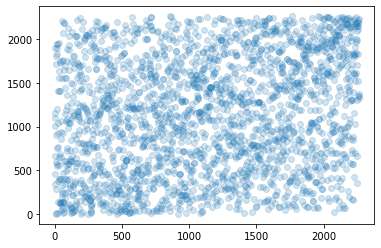

In [213]:
plt.scatter(GSEA["rank"], features_common["rank"], alpha=.2)

In [212]:
stats.kendalltau(GSEA["rank"], features_common["rank"])

KendalltauResult(correlation=0.13960430696551346, pvalue=2.4043316401748344e-23)

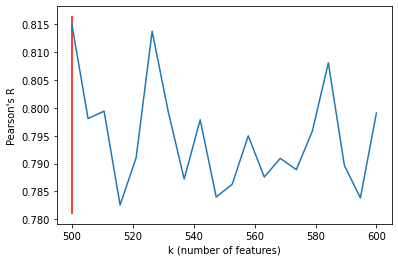

In [132]:
plt.plot(np.linspace(500,600,20),r)
plt.xlabel("k (number of features)")
plt.ylabel("Pearson's R")
plt.vlines(np.linspace(500,600,20)[np.argmax(r)], plt.ylim()[0], plt.ylim()[1], color="red")
plt.savefig("results/feature_selection_lee_GO.png")

In [133]:
X=activity_output
# X=X.reset_index()
# X=X.drop(["index"], axis=1)
loo=LeaveOneOut()
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
feature_selection=SelectKBest(mutual_info_regression,k=500)
X_new=feature_selection.fit_transform(X.to_numpy(), y)
y_pred=[]
y_act=[]
n_genes=[]
for train_index, test_index in loo.split(X_new):
  X_train, X_test = X_new[train_index], X_new[test_index]
  n_genes.append(X_train.shape[1])
  y_train, y_test = y[train_index], y[test_index]
  reg=LinearRegression().fit(X_train,y_train)
  y_pred.append(reg.predict(X_test))
  y_act.append(y_test)
y_pred = np.array([y[0] for y in y_pred])
y_act = np.array([y[0] for y in y_act])
r2, p = pearsonr((y_act),(y_pred))

R2: 0.821
p: 1.035228827567158e-33


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(10, 90, '$R^2$=0.674')

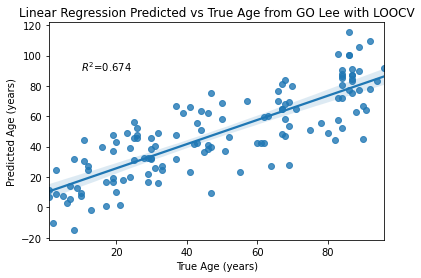

In [134]:
sns.regplot(y_act,y_pred)
r2, p = pearsonr((y_act),(y_pred))
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age from GO Lee with LOOCV")
plt.text(10,90,s="$R^2$=" + str(round(r2**2, 3)))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


R2: 0.821
p: 1.035228827567158e-33


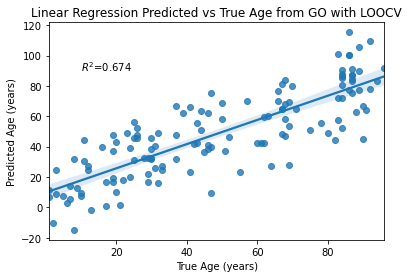

In [136]:
sns.regplot(y_act,y_pred)
r2, p = pearsonr((y_act),(y_pred))
print("R2: " + str(round(r2, 3)))
print("p: " + str(p))
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age from GO with LOOCV")
plt.text(10,90,s="$R^2$=" + str(round(r2**2, 3)))
plt.savefig('results/Lee_GO_pred_true_age_linreg.png')